In [11]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
import seaborn as sns
sns.set_style("darkgrid")

Populating the interactive namespace from numpy and matplotlib


In [2]:
# augment the images
def augmentation(x, max_offset=2):
    bz, h, w, c = x.shape
    bg = np.zeros([bz, w + 2 * max_offset, h + 2 * max_offset, c])
    offsets = np.random.randint(0, 2 * max_offset + 1, 2)
    #shift
    bg[:, offsets[0]:offsets[0] + h, offsets[1]:offsets[1] + w, :] = x
    return bg[:, max_offset:max_offset + h, max_offset:max_offset + w, :]

#mini-batch for single digit training set
def mnist_train_iter(iters=1000, batch_size=32, is_shift_ag=True):
    mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
    max_offset = int(is_shift_ag) * 2
    for i in range(iters):
        batch = mnist.train.next_batch(batch_size)
        images = batch[0].reshape([batch_size, 28, 28, 1])
        images = np.concatenate([images] * 3, axis=-1)
        yield augmentation(images, max_offset), np.stack(
            [batch[1]] * 3, axis=-1)
        # the output is a batch of train set, with 28*28*3 for each pic and 10*3 label for corresponding pic. Shift is possible.

#mini-batch for single digit test set
def mnist_test_iter(iters=1000, batch_size=32, is_shift_ag=False):
    mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
    max_offset = int(is_shift_ag) * 2
    for i in range(iters):
        batch = mnist.test.next_batch(batch_size)
        images = batch[0].reshape([batch_size, 28, 28, 1])
        images = np.concatenate([images] * 3, axis=-1)
        yield augmentation(images, max_offset), np.stack(
            [batch[1]] * 3, axis=-1)
        
#mini-batch for overlapping digit training set
def multimnist_train_iter(iters=1000, batch_size=32, is_shift_ag=True):
    mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
    max_offset = int(is_shift_ag) * 2
    for i in range(iters):
        batch1 = mnist.train.next_batch(batch_size)
        batch2 = mnist.train.next_batch(batch_size)
        images1 = augmentation(batch1[0].reshape([batch_size, 28, 28, 1]),
                               max_offset)
        images2 = augmentation(batch2[0].reshape([batch_size, 28, 28, 1]),
                               max_offset)
        images = np.logical_or(images1, images2).astype(np.float32)
        images = np.concatenate([images, images1, images2], axis=-1)
        y1, y2 = batch1[1], batch2[1]
        y0 = np.logical_or(y1, y2).astype(np.float32)
        yield images, np.stack([y0, y1, y2], axis=-1)

#mini-batch for overlapping digit test set
def multimnist_test_iter(iters=1000, batch_size=32, is_shift_ag=True):
    mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
    max_offset = int(is_shift_ag) * 2
    for i in range(iters):
        #two batch at one iter
        batch1 = mnist.test.next_batch(batch_size)
        batch2 = mnist.test.next_batch(batch_size)
        images1 = augmentation(batch1[0].reshape([batch_size, 28, 28, 1]),
                               max_offset)
        images2 = augmentation(batch2[0].reshape([batch_size, 28, 28, 1]),
                               max_offset)
        #overlapping
        images = np.logical_or(images1, images2).astype(np.float32)
        images = np.concatenate([images, images1, images2], axis=-1)
        y1, y2 = batch1[1], batch2[1]
        y0 = np.logical_or(y1, y2).astype(np.float32)
        yield images, np.stack([y0, y1, y2], axis=-1)
        #size of result is 32*28*28*3, here data in same pos of pics with same index, will be put into one inner array
        #sequence of shift and concatenate is reversible

In [3]:
# A CapsNet class is initiated here to assemble the process of prediction and validation.
# 1. The input is a batch of pics, we need to split the input into 3 different batches
# 2. Use get_CapsNet function
# 2.1 to reach the output layer, with two hidden layer
# 2.2 use process of dynamic routing, do it in iteration, update the output vector
# 3. Use get_mlp_decoder function
# 3.1 for each predicted output and real label, use get_mlp_decoder to reconstruct the input pics
# 4. Cal the difference between reconstructed pics and real pics. Use function to cal the loss and accuracy.
# when we init a class, and input the batches, we could acquire the accuracy from class’s variables.

class CapsNet(object):
    def __init__(self,
                 routing_iterations=3,
                 batch_size=128,
                 is_multi_mnist=True,
                 steps=5000,
                 norm=True,
                 lr_find=False):
        """
        routing_iterations: iterations for routing in CapsNet
        batch_size: data size for every batch
        is_multi_mnist: if it's for single or overlapping image
        steps: epochs 
        norm: if batch_normalization or not
        """
        self.iterations = routing_iterations
        self.batch_size = batch_size
        
        #Single or overlapping image
        self.is_multi_mnist = float(is_multi_mnist)

        self.x = tf.placeholder(tf.float32, [None, 28, 28, 3])
        self.y = tf.placeholder(tf.float32, [None, 10, 3])
        
        if lr_find:
            self.lr = tf.placeholder(tf.float32)
        else:
            #use a exponentially decayed learninig rate
            global_step = tf.Variable(0)
            lr = tf.train.exponential_decay(
                0.00075, global_step, steps / 10, 0.96, staircase=False)
        self.norm = norm
        self.on_train = tf.placeholder(tf.bool)

        x_composed, x_a, x_b = tf.split(self.x, num_or_size_splits=3, axis=3)
        y_composed, y_a, y_b = tf.split(self.y, num_or_size_splits=3, axis=2)
    
        #if not overlapping, mask = tf.ones_like(y_composed[:,0,0])
        #if overlapping: mask = tf.reduce_sum(y_composed, axis=[1,2]) - 1.0
        #for not overlapping: ones_like will generate the array of 1 the same size as input array. Here y_composed[:,0,0], each pic choose only 1 pos, therefore, it is a 1 dimension vector, the size equals batch_size.
        #for overlapping: reduce_sum will sum all num in a range. Here, we choose [1, 2], which is all label for a particular pic. Therefore, reduce_sum here will sum label for each pic in the batch, will represent the num of digits in each pic.
        valid_mask = self.is_multi_mnist * (tf.reduce_sum(y_composed, axis=[1,2]) - 1.0) \
                      + (1.0 - self.is_multi_mnist) * tf.ones_like(y_composed[:,0,0])
        
        #reg_term is the penalty term
        v_digit,reg_term = self.get_CapsNet(x_composed, self.norm, self.on_train)

        length_v = tf.reduce_sum(v_digit**2.0, axis=-1)**0.5
        
        self.y_pred = length_v
        self.y_test = tf.argmax(tf.squeeze(self.y), 1)
        
        x_rec_a = self.get_mlp_decoder(v_digit * y_a)
        x_rec_b = self.get_mlp_decoder(v_digit * y_b, reuse=True)
        loss_rec_a = tf.reduce_sum((x_rec_a - x_a)**2.0, axis=[1, 2, 3])
        loss_rec_b = tf.reduce_sum((x_rec_b - x_b)**2.0, axis=[1, 2, 3])
        self.loss_rec = (loss_rec_a + loss_rec_b) / 2.0
        
        self.loss_cls = tf.reduce_sum(
            y_composed[:, :, 0] * tf.maximum(0.0, 0.9 - length_v)**2.0 + 0.5 *
            (1.0 - y_composed[:, :, 0]) * tf.maximum(0.0, length_v - 0.1)**2.0,
            axis=-1)
        self.loss_cls = tf.reduce_sum(
            self.loss_cls * valid_mask) / tf.reduce_sum(valid_mask)
        #loss_cls: batch_size, valid_mask: _batch_size
        #sum1: loss for all pics in the batch
        #sum2: num of digits for all pics in the batch
        #cal the loss percentage considering y_composed (real label)
        
        self.loss_rec = tf.reduce_sum(
            self.loss_rec * valid_mask) / tf.reduce_sum(valid_mask)
        #loss_rec: batch_size, valid_mask: batch_size
        #sum1: loss for all pics in the batch
        #cal the loss percentage considering prediction from x_composed, x_a, x_b
        
        #loss with the penalty term
        self.loss = self.loss_cls + 0.0005 * self.loss_rec + reg_term
        
        #adam optimizer
        if lr_find:
            self.train = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.loss)
        else:
            self.train = tf.train.AdamOptimizer(
                learning_rate=lr).minimize(
                    self.loss, global_step=global_step)

        #accuracy for single and overlapping training data
        if is_multi_mnist:
            self.accuracy = tf.reduce_mean(tf.cast(tf.nn.in_top_k(length_v,tf.argmax(tf.squeeze(y_a), 1),k=2),tf.float32))+\
                            tf.reduce_mean(tf.cast(tf.nn.in_top_k(length_v,tf.argmax(tf.squeeze(y_b), 1),k=2),tf.float32))
            self.accuracy /= 2.0
        else:
            correct_prediction = tf.equal(
                tf.argmax(y_composed[:, :, 0], 1), tf.argmax(length_v, 1))
            self.accuracy = tf.reduce_mean(
                tf.cast(correct_prediction, tf.float32))

    def get_CapsNet(self, x, norm, on_train, reuse=False):
        """
        norm: to use batch-normalization or not
        on_train: if it's for train or test
        """
        #Two conv layers and a capsule layer
        with tf.variable_scope('CapsNet', reuse=reuse):
            wconv1 = tf.get_variable(
                'wconv1', [9, 9, 1, 256],
                initializer=tf.truncated_normal_initializer(stddev=0.02))
            bconv1 = tf.get_variable(
                'bconv1', [256],
                initializer=tf.truncated_normal_initializer(stddev=0.02))
            wconv2 = tf.get_variable(
                'wconv2', [9, 9, 256, 8 * 32],
                initializer=tf.truncated_normal_initializer(stddev=0.02))
            bconv2 = tf.get_variable(
                'bconv2', [8 * 32],
                initializer=tf.truncated_normal_initializer(stddev=0.02))
            wcap = tf.get_variable(
                'wcap', [1, 6, 6, 32, 8, 10, 16],
                initializer=tf.truncated_normal_initializer(stddev=0.02))
            b = tf.get_variable(
                'coupling_coefficient_logits', [1, 6, 6, 32, 1, 10, 1],
                initializer=tf.constant_initializer(0.0))
        
        #use stop_gradient for debug
        c = tf.stop_gradient(tf.nn.softmax(b, axis=5))
        
        #L2-regularization
        tf.add_to_collection(tf.GraphKeys.WEIGHTS, wconv1)
        tf.add_to_collection(tf.GraphKeys.WEIGHTS, wconv2)
        tf.add_to_collection(tf.GraphKeys.WEIGHTS, wcap)
        regularizer = tf.contrib.layers.l2_regularizer(scale=5.0/50000)
        reg_term = tf.contrib.layers.apply_regularization(regularizer)

        
        if norm:
            # BN for the first input
            fc_mean, fc_var = tf.nn.moments(
                x,
                axes=[0, 1, 2],
            )
            scale = tf.Variable(tf.ones([1]))
            shift = tf.Variable(tf.zeros([1]))
            epsilon = 0.001
            ema = tf.train.ExponentialMovingAverage(decay=0.5)

            def mean_var_with_update():
                """
                update mean and variance using moving average
                """
                ema_apply_op = ema.apply([fc_mean, fc_var])
                with tf.control_dependencies([ema_apply_op]):
                    return tf.identity(fc_mean), tf.identity(fc_var)
            
            # if it's for test, then don't update mean and var, instead use the fc_mean and fc_var that already calculated
            mean, var = tf.cond(
                on_train, mean_var_with_update,
                lambda: (ema.average(fc_mean), ema.average(fc_var)))
            x = tf.nn.batch_normalization(x, mean, var, shift, scale, epsilon)

        conv1 = tf.nn.conv2d(x, wconv1, [1, 1, 1, 1], padding='VALID') + bconv1

        if norm:
            # BN for the first conv layer
            fc_mean, fc_var = tf.nn.moments(
                conv1,
                axes=[0, 1, 2],
            )
            scale = tf.Variable(tf.ones([1]))
            shift = tf.Variable(tf.zeros([1]))
            epsilon = 0.001
            ema = tf.train.ExponentialMovingAverage(decay=0.5)

            def mean_var_with_update():
                ema_apply_op = ema.apply([fc_mean, fc_var])
                with tf.control_dependencies([ema_apply_op]):
                    return tf.identity(fc_mean), tf.identity(fc_var)

            mean, var = tf.cond(
                on_train, mean_var_with_update,
                lambda: (ema.average(fc_mean), ema.average(fc_var)))
            conv1 = tf.nn.batch_normalization(conv1, mean, var, shift, scale,
                                              epsilon)

        conv1 = tf.nn.relu(conv1)

        s_primary = tf.nn.conv2d(
            conv1, wconv2, [1, 2, 2, 1], padding='VALID') + bconv2

        if norm:
            # BN for the second conv layer
            fc_mean, fc_var = tf.nn.moments(
                s_primary,
                axes=[0, 1, 2],
            )
            scale = tf.Variable(tf.ones([1]))
            shift = tf.Variable(tf.zeros([1]))
            epsilon = 0.001
            ema = tf.train.ExponentialMovingAverage(decay=0.5)

            def mean_var_with_update():
                ema_apply_op = ema.apply([fc_mean, fc_var])
                with tf.control_dependencies([ema_apply_op]):
                    return tf.identity(fc_mean), tf.identity(fc_var)

            mean, var = tf.cond(
                on_train, mean_var_with_update,
                lambda: (ema.average(fc_mean), ema.average(fc_var)))
            s_primary = tf.nn.batch_normalization(s_primary, mean, var, shift,
                                                  scale, epsilon)

        s_primary = tf.reshape(s_primary, [-1, 6, 6, 32, 8, 1, 1])
        #change form from batch_size*6*6*256 into -1*6*6*32*8*1*1. For input of capsule, it contains 6*6*32 vectors, each vector has 8 elements. We could consider it as reshape the 256 output layer into 8 groups, each group contains 32 layer. Put 8 groups parallel and each vector is the pix in same positions in 8 groups. 
        #the use of 1, 1 will make it easy to cal when we do u*wcap in the following step. (* is the multiply by elements in corresponding pos) (expand automatically, but we need to keep same dimensions first)

        v_primary = self.squash(s_primary, axis=4)

        #CAPSNET
        u = v_primary #input of capsule
        u_ = tf.reduce_sum(u * wcap, axis=[4], keepdims=True)
        s = tf.reduce_sum(u_ * c, axis=[1, 2, 3], keepdims=True)
        v = self.squash(s, axis=-1)

        if norm:
            # BN for the capsule layer
            fc_mean, fc_var = tf.nn.moments(
                v,
                axes=[0, 1, 2],
            )
            scale = tf.Variable(tf.ones([1]))
            shift = tf.Variable(tf.zeros([1]))
            epsilon = 0.001
            ema = tf.train.ExponentialMovingAverage(decay=0.5)

            def mean_var_with_update():
                ema_apply_op = ema.apply([fc_mean, fc_var])
                with tf.control_dependencies([ema_apply_op]):
                    return tf.identity(fc_mean), tf.identity(fc_var)

            mean, var = tf.cond(
                on_train, mean_var_with_update,
                lambda: (ema.average(fc_mean), ema.average(fc_var)))
            v = tf.nn.batch_normalization(v, mean, var, shift, scale, epsilon)

        for i in range(self.iterations - 1):
            b += tf.reduce_sum(u_ * v, axis=-1, keepdims=True)
            c = tf.nn.softmax(b, axis=5)
            s = tf.reduce_sum(u_ * c, axis=[1, 2, 3], keepdims=True)
            v = self.squash(s, axis=-1) #get the correct v

        v_digit = tf.squeeze(v)

        return v_digit,reg_term

    def get_mlp_decoder(self, h, num_h=[10 * 16, 512, 1024, 784], reuse=False):
        """
        restruction the input images: 160 -> 512 -> 1024 -> 784
        """
        h = tf.reshape(h, [-1, 10 * 16])
        with tf.variable_scope('decoder', reuse=reuse):
            weights = []
            for i in range(len(num_h) - 1):
                w = tf.get_variable(
                    'wfc%d' % i, [num_h[i], num_h[i + 1]],
                    initializer=tf.truncated_normal_initializer(stddev=0.02))
                b = tf.get_variable(
                    'bfc%d' % i, [num_h[i + 1]],
                    initializer=tf.truncated_normal_initializer(stddev=0.02))
                weights.append((w, b))
                if i < len(num_h) - 2:
                    h = tf.nn.relu(tf.add(tf.matmul(h, w), b))
                else:
                    h = tf.nn.sigmoid(tf.add(tf.matmul(h, w), b))
        x_rec = tf.reshape(h, [-1, 28, 28, 1])
        return x_rec

    def squash(self, s, axis=-1):
        length_s = tf.reduce_sum(s**2.0, axis=axis, keepdims=True)**0.5
        v = s * length_s / (1.0 + length_s**2.0) #shorten the length of each vector, make the length a little shorter than 1. Non-linear. To avoid the existence of 0 vector.
        return v

In [4]:
batch_size = 64
is_multi_mnist = True
is_shift_ag = True
irun = 0
steps = 3000
lr_find = False
lr_list = []
loss_list = []

### We first try to find the best lr by increasing it by every iter and see at what iter the corresponding lr is doing the best

In [ ]:
lr_find = True
lr = 1e-5

In [ ]:
if is_multi_mnist:
    train_iter = multimnist_train_iter(
        iters=steps, batch_size=batch_size, is_shift_ag=True)
    test_iter = multimnist_test_iter(
        iters=steps, batch_size=batch_size, is_shift_ag=True)
else:
    train_iter = mnist_train_iter(
        iters=steps, batch_size=batch_size, is_shift_ag=True)
    test_iter = mnist_test_iter(
        iters=steps, batch_size=batch_size, is_shift_ag=True)

net = CapsNet(is_multi_mnist=is_multi_mnist, steps=steps, lr_find=lr_find)

init = tf.global_variables_initializer()

sess = tf.Session()

sess.run(init)

for X, Y in train_iter:
    X_TEST, Y_TEST = next(test_iter)
    
    if lr_find:
        LS, LS_REC, ACC, _ = sess.run([net.loss, net.loss_rec, net.accuracy, net.train], feed_dict={net.x: X, net.y: Y, net.on_train:True ,net.lr: lr})
        lr_list.append(lr)
        loss_list.append(LS)
        if irun % 100 == 0:
            print(irun, LS, ACC)
        lr += np.linspace(1e-5,1e-2,steps)[2]-np.linspace(1e-5,1e-2,steps)[1]   
        
    else:    
        LS, LS_REC, ACC, _ = sess.run(
            [net.loss, net.loss_rec, net.accuracy, net.train],
            feed_dict={
                net.x: X,
                net.y: Y,
                net.on_train: True
            })
        ACC_TEST = sess.run(
            net.accuracy,
            feed_dict={
                net.x: X_TEST,
                net.y: Y_TEST,
                net.on_train: False
            })

        if irun % 100 == 0:
            print(irun, LS, ACC, ACC_TEST)

    irun += 1

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(lr_list,loss_list);

### From the figure above, we are going to let lr = 0.00075

In [5]:
lr_find = False
steps = 5000

In [6]:
import time
from sklearn.metrics import roc_auc_score, f1_score

In [7]:
if is_multi_mnist:
    train_iter = multimnist_train_iter(
        iters=steps, batch_size=batch_size, is_shift_ag=True)
    test_iter = multimnist_test_iter(
        iters=steps, batch_size=batch_size, is_shift_ag=True)
else:
    train_iter = mnist_train_iter(
        iters=steps, batch_size=batch_size, is_shift_ag=True)
    test_iter = mnist_test_iter(
        iters=steps, batch_size=batch_size, is_shift_ag=True)

F1_OS=[]    
    
net = CapsNet(is_multi_mnist=is_multi_mnist, steps=steps, lr_find=lr_find)

init = tf.global_variables_initializer()

#For model saving
saver = tf.train.Saver()

sess = tf.Session()

sess.run(init)

for X, Y in train_iter:
    a = time.time()
    X_TEST, Y_TEST = next(test_iter)

    if lr_find:
        LS, LS_REC, ACC, _ = sess.run(
            [net.loss, net.loss_rec, net.accuracy, net.train],
            feed_dict={
                net.x: X,
                net.y: Y,
                net.on_train: True,
                net.lr: lr
            })
        lr_list.append(lr)
        loss_list.append(LS)
        if irun % 100 == 0:
            print(irun, LS, ACC)
        lr += np.linspace(1e-5, 1e-2, steps)[2] - np.linspace(
            1e-5, 1e-2, steps)[1]

    else:
        LS, LS_REC, ACC, _, y_pred,y_test = sess.run(
            [net.loss, net.loss_rec, net.accuracy, net.train,net.y_pred,net.y_test],
            feed_dict={
                net.x: X,
                net.y: Y,
                net.on_train: True
            })
        
        sum1=[]
        
        for i in range(y_test.shape[1]):
            sum1.append(f1_score(y_test[:,i],np.argmax(y_pred,1),average='micro'))
        
        F1_OS.append(np.mean(sum1))
        
        ACC_TEST = sess.run(
            net.accuracy,
            feed_dict={
                net.x: X_TEST,
                net.y: Y_TEST,
                net.on_train: False
            })

        b = time.time()
        if irun % 100 == 0:
            print(irun, LS, ACC, ACC_TEST, '{}s per epoch'.format(b - a))

        if (irun + 1) % 1000 == 0:
            saver.save(sess, "./checkpoint_CapsNet/MyModel")
            print('Model Saved!')
    
    irun += 1

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0 1.6172688 0.265625 0.25 1.9486184120178223s per epoch
100 0.62038404 0.65625 0.6796875 0.09177398681640625s per epoch
200 0.4850719 0.75 0.6796875 0.09191060066223145s per epoch
300 0.4585455 0.796875 0.75 0.09154438972473145s per epoch
400 0.44560006 0.765625 0.7578125 0.09256172180175781s per epoch
500 0.49684155 0.75 0.7421875 0.09416866302490234s per epoch
600 0.46489134 0.75 0.75 0.09290385246276855s per epoch
700 0.4135639 0.828125 0.7421875 0.0922236442565918s per epoch
800 0.3878246 0.8203125 0.7421875 0.09235525131225586s per epoch
900 0.38546354 0.859375 0.8203125 0.09260845184326172s per epoc

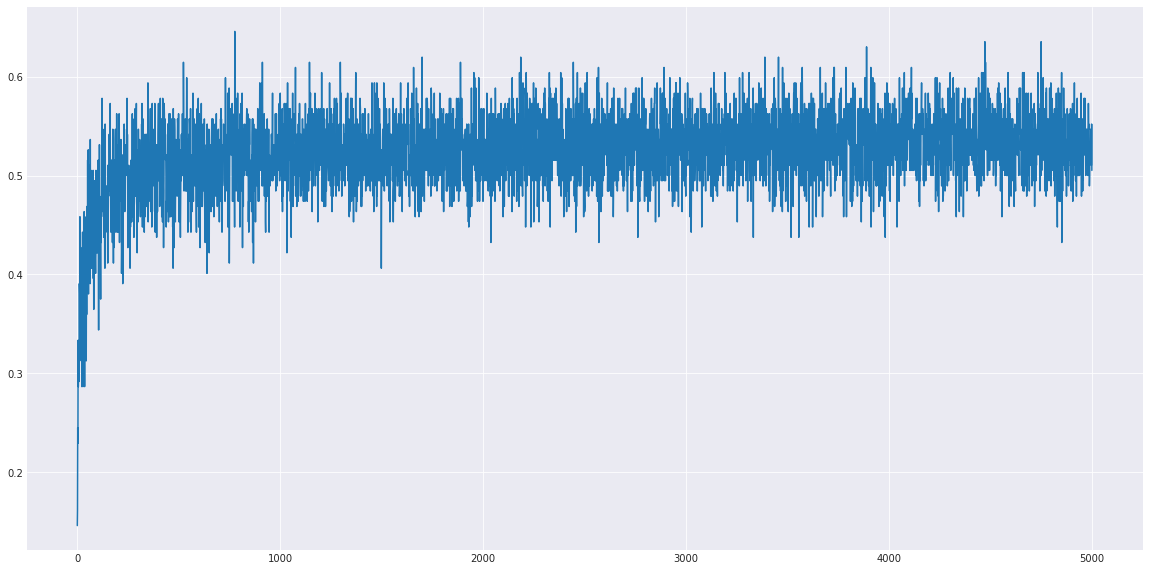

In [15]:
plt.figure(figsize=(20,10))
plt.plot(range(5000),F1_OS)